# Imports

In [60]:
import pandas as pd
import numpy as np 
import sqlite3
import nltk
#nltk.download("vader_lexicon")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import scipy as sp
import sqlite3
import re
from datetime import datetime
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy.stats import pearsonr

%matplotlib inline

In [10]:
conn = sqlite3.connect("/Users/jackmackle/py_work/uranium-twitter-bot/storage/storage.db")
df = pd.read_sql_query("SELECT * FROM tweets", conn)
conn.close()

# VADER

I chose this model for three reasons:
1. I was able to use it on unlabelled data.
2. When I searched "sentiment analysis" it was one of the first things to come up. 
3. I read an interesting paper (source below) that used this same model to classify tweets relating to the 2016 US election. 

Elbagir, S., &amp; Yang, J. (2020). Sentiment analysis on Twitter with Python’s Natural Language Toolkit and vader sentiment analyzer. 
    IAENG Transactions on Engineering Sciences. https://doi.org/10.1142/9789811215094_0005 

In [11]:
sid = SentimentIntensityAnalyzer()

In [12]:
tw_text_list = df["full_text"].tolist()
polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

In [13]:
df["compound_pol"] = compound

In [14]:
strip_date = list(map(lambda x: x.split()[0], df["created_at"].to_list()))
df["stripdate"] = strip_date

In [27]:
df_date_group = df[["stripdate", "compound_pol"]].groupby("stripdate", as_index=False).agg(['count','mean']).reset_index()

In [24]:
df_clean = df

tw_text_list = df_clean["full_text"].tolist()

def remove_handles(text):
    r = re.findall("@[\w]*", text)
    for i in r:
        text = re.sub(i, "", text)
        
    return text

tw_text_list = list(map(remove_handles, tw_text_list))

def remove_links(text):
    r = re.findall("https?://[A-Za-z0-9./]*", text)
    for i in r:
        text = re.sub(i, "", text)
        
    return text

tw_text_list = list(map(remove_links, tw_text_list))

polarity_scores = list(map(sid.polarity_scores, tw_text_list))
compound = list(map(lambda x: x["compound"], polarity_scores))

df_clean["compound_pol"] = compound

df_clean_date_group = df_clean[["stripdate", "compound_pol"]].groupby("stripdate", as_index=False).agg(['count','mean']).reset_index()

In [26]:
diff = np.subtract(df_clean_date_group["compound_pol"]["mean"], df_date_group["compound_pol"]["mean"])

clean_vs_unclean = pd.DataFrame({"date" : df_date_group["stripdate"],
                                 "clean_cpol" : df_clean_date_group["compound_pol"]["mean"],
                                 "unclean_cpol" : df_date_group["compound_pol"]["mean"],
                                 "diff" : diff})

clean_vs_unclean

,date,clean_cpol,unclean_cpol,diff
0,2022-02-22,0.176889,0.176889,0.0
1,2022-02-23,0.204645,0.204645,0.0
2,2022-02-24,0.147176,0.147176,0.0
3,2022-02-25,0.202389,0.202389,0.0
4,2022-02-26,0.225790,0.225790,0.0
5,2022-02-27,0.142606,0.142606,0.0
6,2022-02-28,0.147505,0.147505,0.0
7,2022-03-01,0.211371,0.211371,0.0
8,2022-03-02,0.159918,0.159918,0.0
9,2022-03-03,0.197516,0.197516,0.0


So, here I (lazily) tried to see if cleaning the raw text from the pulled tweets resulted in differences in the daily average sentiment. The data shows there is no differences when removing links or handles.

Some more work could be done here:
1. Links and handles were the only items removed in the cleaned data set. I could also remove the "#" from any hashtags.

# EDA

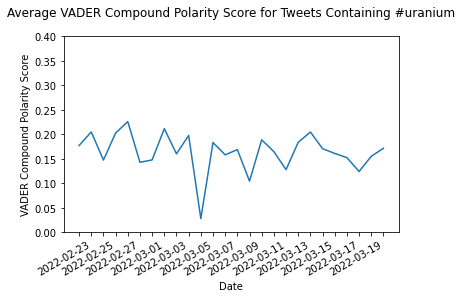

In [61]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(df_date_group["stripdate"],
         df_date_group["compound_pol"]["mean"],
         label="Compound Polarity Score")
fig.autofmt_xdate()
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
ax1.set_title("Average VADER Compound Polarity Score for Tweets Containing #uranium",
              pad=20)
ax1.set_ylabel("VADER Compound Polarity Score")
ax1.set_xlabel("Date")
ax1.set_ylim([0,.4])

plt.show()

So first thing I wanted to check out was the average sentiment over time. I'm using the unclean data because I don't really think it matters. 

A couple things to note:
- This looks very familiar to uranium investors. We are used to staring at charts that resemble a sine curve. 
- The huge dive around March 4th/5th is good to see. Around this time, there was news of Russia shelling at the Zaporizhzhia NPP, which sent the market into a panic sell. 

In [29]:
df_sput = pd.read_csv("sput-data.txt",
                      sep="\t",
                      index_col=None,
                      header=None)
df_dml = pd.read_csv("dml-data.txt",
                      sep="\t",
                      index_col=None,
                      header=None)

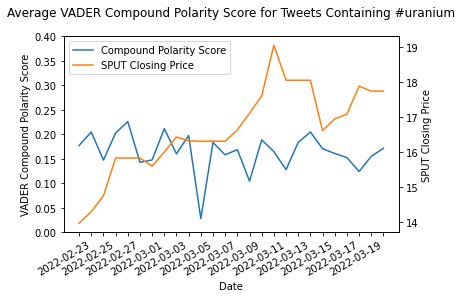

In [32]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(df_date_group["stripdate"],
         df_date_group["compound_pol"]["mean"],
         label="Compound Polarity Score")
fig.autofmt_xdate()
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
ax1.set_title("Average VADER Compound Polarity Score for Tweets Containing #uranium",
              pad=20)
ax1.set_ylabel("VADER Compound Polarity Score")
ax1.set_xlabel("Date")
ax1.set_ylim([0,.4])

ax2 = ax1.twinx()
ln2 = ax2.plot(df_date_group["stripdate"],
        df_sput[1],
        color="tab:orange",
        label="SPUT Closing Price")
ax2.set_ylabel("SPUT Closing Price")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

plt.show()

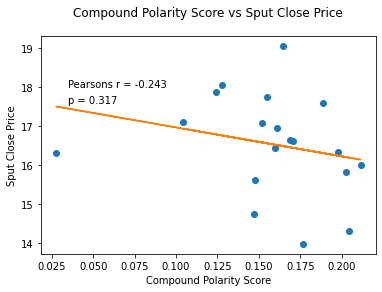

In [74]:
df_sent_sput = pd.DataFrame({"date" : df_date_group["stripdate"],
                             "compound_pol" : df_date_group["compound_pol"]["mean"],
                             "sput_close" : df_sput[1]})

#we have to remove weekends - drop duplicates seemed to work with fucking the dates

df_sent_sput = df_sent_sput.drop_duplicates(subset=["sput_close"])

#pearson correlation
corr, p = pearsonr(df_sent_sput["compound_pol"], df_sent_sput["sput_close"])

#linreg
params = np.polyfit(df_sent_sput["compound_pol"], 
                       df_sent_sput["sput_close"],
                       1)
y_line = params[1] + params[0] * df_sent_sput["compound_pol"]

fig, ax = plt.subplots()

ax.scatter(df_sent_sput["compound_pol"],
           df_sent_sput["sput_close"])
ax.set_ylabel("Sput Close Price")
ax.set_xlabel("Compound Polarity Score")
ax.set_title("Compound Polarity Score vs Sput Close Price",
             pad=20)
ax.plot(df_sent_sput["compound_pol"],
        y_line,
        color="tab:orange")

plt.text(0.035, 18, f"Pearsons r = {round(corr, 3)}")
plt.text(0.035, 17.6, f"p = {round(p, 3)}")
plt.show()



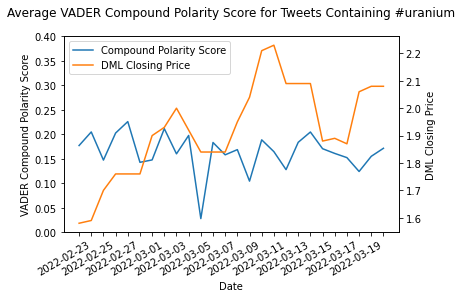

In [33]:
fig, ax1 = plt.subplots()
ln1 = ax1.plot(df_date_group["stripdate"],
         df_date_group["compound_pol"]["mean"],
         label="Compound Polarity Score")
fig.autofmt_xdate()
for label in ax1.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
    
ax1.set_title("Average VADER Compound Polarity Score for Tweets Containing #uranium",
              pad=20)
ax1.set_ylabel("VADER Compound Polarity Score")
ax1.set_xlabel("Date")
ax1.set_ylim([0,.4])

ax2 = ax1.twinx()
ln2 = ax2.plot(df_date_group["stripdate"],
        df_dml[1],
        color="tab:orange",
        label="DML Closing Price")
ax2.set_ylabel("DML Closing Price")

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=2)

plt.show()

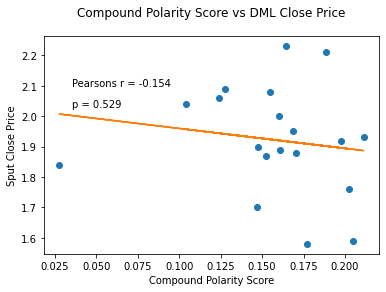

In [72]:
df_sent_sput = pd.DataFrame({"date" : df_date_group["stripdate"],
                             "compound_pol" : df_date_group["compound_pol"]["mean"],
                             "dml_close" : df_dml[1]})

#we have to remove weekends - drop duplicates seemed to work with fucking the dates

df_sent_dml = df_sent_sput.drop_duplicates(subset=["dml_close"])

#pearson correlation
corr, p = pearsonr(df_sent_dml["compound_pol"], df_sent_dml["dml_close"])

#linreg
params = np.polyfit(df_sent_dml["compound_pol"], 
                       df_sent_dml["dml_close"],
                       1)
y_line = params[1] + params[0] * df_sent_dml["compound_pol"]

fig, ax = plt.subplots()

ax.scatter(df_sent_dml["compound_pol"],
           df_sent_dml["dml_close"])
ax.set_ylabel("Sput Close Price")
ax.set_xlabel("Compound Polarity Score")
ax.set_title("Compound Polarity Score vs DML Close Price",
             pad=20)
ax.plot(df_sent_dml["compound_pol"],
        y_line,
        color="tab:orange")

plt.text(0.035, 2.1, f"Pearsons r = {round(corr, 3)}")
plt.text(0.035, 2.03, f"p = {round(p, 3)}")
plt.show()

Now, obviously, the next step was to overlay some of my favourite tickers and see if there is any correlation here.

From the eye test, the data tells us in both cases (SPUT and DML) don't really look correlated. This is further supported by the high p-values.

With that said, I'll ignore the eye test and the p-values and think "yeah, DML and SPUT are negatively correlated to twitter sentiment. That makes a lot of sense."